In [1]:
# Cell 2: Import & check installation
import torch, torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import fiftyone as fo
import fiftyone.zoo as foz

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA available: True


In [2]:
# Cell 3 : Load RetinaNet with ResNet-50 backbone
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights

# Use latest recommended weights
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT # (Trained on COCO dataset, 91 classes)
model = retinanet_resnet50_fpn(weights=weights)
model.eval().cuda()

print("✅ RetinaNet (ResNet-50 FPN) loaded with COCO pretrained weights on GPU")


✅ RetinaNet (ResNet-50 FPN) loaded with COCO pretrained weights on GPU


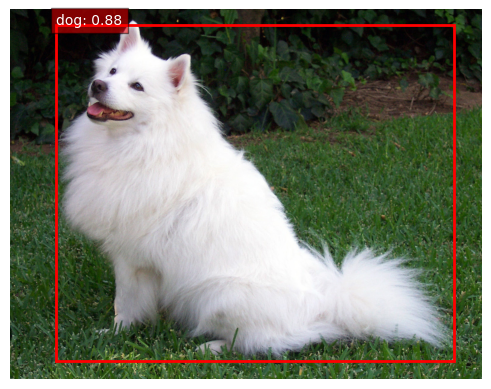

In [3]:
# Cell 4: Inference on a sample image with RetinaNet (fixed for CUDA tensors)

import requests
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Load labels for COCO
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
coco_labels = weights.meta["categories"]

# ✅ Direct JPG image link (dog)
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Preprocess
transform = weights.transforms() # (800 px short side, max 1333 px long side).
img_tensor = transform(image).unsqueeze(0).cuda()

# Inference
with torch.no_grad():
    preds = model(img_tensor)[0]

# Move predictions to CPU for plotting
boxes = preds['boxes'].cpu()
scores = preds['scores'].cpu()
labels = preds['labels'].cpu()

# Show detections
plt.imshow(image)
ax = plt.gca()

for box, score, label in zip(boxes, scores, labels):
    if score > 0.75:  # confidence threshold
        x1, y1, x2, y2 = box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color='red', linewidth=2))
        ax.text(x1, y1, f"{coco_labels[label]}: {score:.2f}",
                fontsize=10, color='white', bbox=dict(facecolor='red', alpha=0.5))

plt.axis("off")
plt.show()
